In [1]:
import scanpy.external as sce
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler
from seaborn import despine
from seaborn import axes_style
from matplotlib.pyplot import suptitle
import magic # imputation tool; van Dijk et al 2018 # 
import matplotlib.colors
import scvelo as scv

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

subset_results_file = '/n/data2/bch/hemonc/ckim/AARON/KY_epithelial_analysis/write/invivo_epithelial_subset.h5ad'
adata_subset = sc.read(subset_results_file)

# Work around for re-laoding issue in Scanpy
adata_subset.raw._varm = None

/home/alm72/.conda/envs/KYorg_env/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


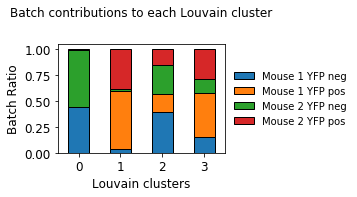

In [4]:
df=adata_subset.obs
df_plot = df.groupby(['batch', 'louvain_r0.2']).size().reset_index().pivot(columns='batch', index='louvain_r0.2', values=0)

# normalize rows
# Credit: https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
df3 = df_plot.div(df_plot.sum(axis=1), axis=0)

# plot
rcParams['figure.figsize'] = 3,2
with axes_style({'axes.grid': False}):
    df3.plot(kind='bar', stacked=True, edgecolor='Black')
plt.ylabel('Batch Ratio', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.title('Batch contributions to each Louvain cluster',fontsize=12, y = 1.2)
plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, frameon=False)

In [5]:
print('Number of cells per louvain cluster:')
adata_subset.obs['louvain_r0.2'].value_counts()

Number of cells per louvain cluster:


0    3402
1    2731
2    1740
3     455
Name: louvain_r0.2, dtype: int64

#### Transcription Factor and Co-factor identification

In [26]:
# identify all DE TF's 

# import list of mouse TFs from TFDB
# http://bioinfo.life.hust.edu.cn/AnimalTFDB/#!/species
df_tf = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='TF and TFCs Animal TFDB3', header=0) # load lists 
tf_genes = set(df_tf['Symbol'].tolist())

# Find TF/TFCs in the filtered DE genes list
# Manaully filtered for pval < 0.05
diff_padj_filtered = pd.read_excel("at2_only_DE_top1000_filtered.xlsx", header = 0) # previously generated using in built ScanPy function
names = diff_padj_filtered.columns

clust_dict = {} #key,value

for col in diff_padj_filtered.columns:
    
    # get diff gene list
    cluster_genes = diff_padj_filtered[col].tolist()

    # Create results array
    results_tfs = []

    # iterate through and pull out TF/TFCs
    
    for i in tf_genes:
     if i in cluster_genes:
      results_tfs.append(i)
    
    #store in dict (receptors,ligands,tfs)
    the_key = col
    the_value = {}
    the_value["tfs"] = results_tfs
    clust_dict[the_key] = the_value

# Create a list of identified TFs
merged_tf = []

for i in clust_dict:
    sub_dict = clust_dict[i] #access each cluster in dict
    
    # create merge
    merged_tf += sub_dict["tfs"]
    
# Print result
print('Total sig DE TF in AT2 cluster:',len(merged_tf))

Total sig DE TF in AT2 cluster: 82


In [31]:
# Create dictionary for C0 and C1 specific TFS

print('Results')

at2_DE_data = pd.read_excel("at2_only_DE_top1000_filtered.xlsx", header = 0) # previously generated using in built ScanPy function
neg_list = list(at2_DE_data['0_n'])
pos_list = list(at2_DE_data['1_n'])

# import list of mouse TFs from TFDB
# http://bioinfo.life.hust.edu.cn/AnimalTFDB/#!/species
df_tf = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='TF and TFCs Animal TFDB3', header=0) # load lists 
tf_genes = set(df_tf['Symbol'].tolist())

# make dictionary
at2_tf_dict = {}

at2_tf_dict.update({'Cluster 0 AT2 YFP neg TF':[x for x in neg_list if x in tf_genes]})
at2_tf_dict.update({'Cluster 1 AT2 YFP pos TF':[x for x in pos_list if x in tf_genes]})

for k,v in at2_tf_dict.items():
    print(f'Number of {k} TF/TFCs:',len(v))
# sum should == len(merged_tf)

Results
Number of Cluster 0 AT2 YFP neg TF TF/TFCs: 32
Number of Cluster 1 AT2 YFP pos TF TF/TFCs: 50


In [32]:
# Print results
at2_tf_dict

{'Cluster 0 AT2 YFP neg TF': ['Etv5',
  'Irx1',
  'Irx2',
  'Id2',
  'Nkx2-1',
  'Rbpjl',
  'Srebf2',
  'Elf3',
  'Epas1',
  'Ets2',
  'Irf1',
  'Xbp1',
  'Bhlhe40',
  'Zbtb4',
  'Rora',
  'Foxo3',
  'Ddit3',
  'Nfe2l2',
  'Irx5',
  'Pias1',
  'Tfcp2l1',
  'Nfil3',
  'Gata6',
  'Zfp503',
  'Batf',
  'Thra',
  'Foxa2',
  'Stat3',
  'Prdm1',
  'Baz2b',
  'Foxa1',
  'Mta3'],
 'Cluster 1 AT2 YFP pos TF': ['Egr1',
  'Fosb',
  'Ybx1',
  'Nr4a2',
  'Hmgb1',
  'Klf4',
  'Creb3l1',
  'Jund',
  'Maff',
  'Klf2',
  'Tgif1',
  'Fos',
  'Nr4a1',
  'Phb',
  'Id1',
  'Pbx1',
  'Jun',
  'Foxq1',
  'Atf5',
  'Etv4',
  'Nme2',
  'Atf3',
  'Zfp706',
  'E2f4',
  'Plscr1',
  'Litaf',
  'Arid4b',
  'Sub1',
  'Myc',
  'Mbd3',
  'Nfia',
  'Arid5b',
  'Klf6',
  'Elf5',
  'Gtf3a',
  'Tshz2',
  'Nr4a3',
  'Trp53',
  'Hmgb3',
  'Tox',
  'Zfp131',
  'Tsc22d3',
  'Hmg20b',
  'Klf5',
  'Egr2',
  'Gatad1',
  'Cebpa',
  'Relb',
  'Stat1',
  'Tcf25']}

#### Plot 

In [ ]:
# Create AT2 cluster subset
adata_at2 = adata_subset[adata_subset.obs['louvain_r0.2'].isin(['0','1'])]

Text(0, 0.5, 'Expression')

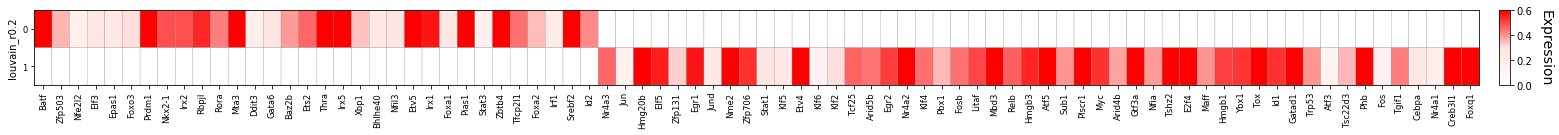

In [44]:
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'mistyrose','red'])

# significantly improves visual
adata_at2_scaled = sc.pp.scale(adata_at2, copy=True)

rcParams['figure.figsize'] = 10,3
sc.pl.matrixplot(adata_at2_scaled, var_names=merged_tf, cmap=cmap2, groupby='louvain_r0.2', use_raw=False, 
swap_axes=False, vmin=0, vmax=0.6, dendrogram=False, show=False)
plt.ylabel('Expression',fontsize=14,labelpad=20,rotation=270)

#### Plot signature score data

##### Kras activation signature

In [26]:
# Perform a Mann Whitney U test for Kras signature
cat0 = adata_at2.obs[(adata_at2.obs['louvain_r0.2'] == '0')]
cat1 = adata_at2.obs[(adata_at2.obs['louvain_r0.2'] == '1')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
print(mannwhitneyu(cat0['Kras activation signature'], cat1['Nfkb activation signature']))

MannwhitneyuResult(statistic=2252473.0, pvalue=1.7304407742398304e-264)


Text(1, 2, '***')

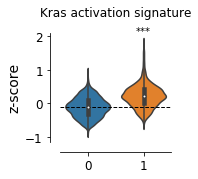

In [22]:
df=adata_at2.obs
df_1 = pd.pivot_table(df, values='Kras activation signature', index='index1', columns='louvain_r0.2')
value_df = pd.DataFrame(df_1.median())

rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Kras activation signature', x='louvain_r0.2', data=adata_at2.obs)
despine(right=True, offset=10)
plt.title('Kras activation signature', fontsize=12, y=1.1)
plt.ylabel('z-score', fontsize=14)
plt.xlabel('', fontsize=14)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(value_df[0].iloc[0], color='black', linestyle='dashed', linewidth = 1)

# statistical annotation
x1 = 1  
y, h, col = adata_at2.obs['Nfkb activation signature'].max() + 2, 2, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

##### Nfkb activation signature

In [4]:
# Perform a Mann Whitney U test for Nfkb signature
cat0 = adata_at2.obs[(adata_at2.obs['louvain_r0.2'] == '0')]
cat1 = adata_at2.obs[(adata_at2.obs['louvain_r0.2'] == '1')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
print(mannwhitneyu(cat0['Nfkb activation signature'], cat1['Nfkb activation signature']))

MannwhitneyuResult(statistic=2633919.0, pvalue=1.353055398712846e-187)


Text(1, 3, '***')

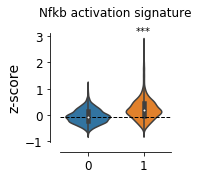

In [21]:
df=adata_at2.obs
df_1 = pd.pivot_table(df, values='Nfkb activation signature', index='index1', columns='louvain_r0.2')
value_df = pd.DataFrame(df_1.median())

# Plot results
rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Nfkb activation signature', x='louvain_r0.2', data=adata_at2.obs)
despine(right=True, offset=10)
plt.title('Nfkb activation signature', fontsize=12, y=1.1)
plt.ylabel('z-score', fontsize=14)
plt.xlabel('', fontsize=14)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(value_df[0].iloc[0], color='black', linestyle='dashed', linewidth = 1)

# statistical annotation
x1 = 1  
y, h, col = adata_at2.obs['Nfkb activation signature'].max() + 3, 3, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

##### Proliferation signature

In [27]:
# Perform a Mann Whitney U test for Nfkb signature
cat0 = adata_at2.obs[(adata_at2.obs['louvain_r0.2'] == '0')]
cat1 = adata_at2.obs[(adata_at2.obs['louvain_r0.2'] == '1')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
print(mannwhitneyu(cat0['Proliferation signature'], cat1['Proliferation signature']))

MannwhitneyuResult(statistic=1878734.0, pvalue=0.0)


Text(1, 10, '***')

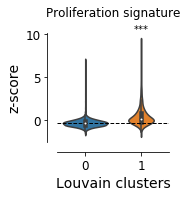

In [29]:
# Plot

df=adata_at2.obs
df_1 = pd.pivot_table(df, values='Proliferation signature', index='index1', columns='louvain_r0.2')
value_df = pd.DataFrame(df_1.median())

rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Proliferation signature', x='louvain_r0.2', data=adata_at2.obs)
despine(right=True, offset=10)
plt.title('Proliferation signature', fontsize=12, y=1.1)
plt.ylabel('z-score', fontsize=14)
plt.xlabel('Louvain clusters', fontsize=14)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(value_df[0].iloc[0], color='black', linestyle='dashed', linewidth = 1)

# statistical annotation
x1 = 1  
y, h, col = adata_at2.obs['Proliferation signature'].max() + 10, 10, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

### GO analysis using AT2 clusters only

In [34]:
mouse_DE_df = pd.read_excel("at2_only_DE_top1000_filtered.xlsx", header = 0) 

# Look for enriched Gene Ontology Biological Process 2018 pathways
%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
import gseapy as gp
from gseapy.plot import barplot, dotplot 

#view available reference libraries
names = gp.get_library_name() # a list of available libraries will appear

C0 = mouse_DE_df['0_n']
C1 = mouse_DE_df['1_n']

# drop NaN
C0=C0.dropna()
C1=C1.dropna()

# GO Analysis

Cluster0_GOBio = gp.enrichr(gene_list = C0,
description='Cluster0_GOBio',
gene_sets=['GO_Biological_Process_2018'],
outdir='Enricher_analysis/Cluster0_AT2only_GOBio',
cutoff=0.05
)

Cluster1_GOBio = gp.enrichr(gene_list = C1,
description='Cluster1_GOBio',
gene_sets=['GO_Biological_Process_2018'],
outdir='Enricher_analysis/Cluster1_AT2only_GOBio',
cutoff=0.05
)

# filter for statistically significant terms

c0_sig = Cluster0_GOBio.res2d.loc[(Cluster0_GOBio.res2d['Adjusted P-value'] < 0.05)] 
c1_sig = Cluster1_GOBio.res2d.loc[(Cluster1_GOBio.res2d['Adjusted P-value'] < 0.05)] 

c0_list = c0_sig['Term'].tolist() # at2 neg
c1_list = c1_sig['Term'].tolist() # at2 pos

print('# All C0 terms:',len(c0_list))
print('# All C1 terms:',len(c1_list))

# look for unique and common terms in C1 and C0

c0_unique_terms = []
c1_unique_terms = []
common_terms = []

for i in c0_list:
    if i not in c1_list:
        c0_unique_terms.append(i)

for i in c1_list:
    if i not in c0_list:
        c1_unique_terms.append(i)
               
for i in c1_list:
    if i in c0_list:
        common_terms.append(i)   

print('# CO Terms:', len(c0_unique_terms))
print('# C1 Terms:', len(c1_unique_terms))
print('# Common Terms:', len(common_terms))

# Add data to adata_uns
GO_analysis_AT2_clusters_only = {}
GO_analysis_AT2_clusters_only.update({'Common_Terms':common_terms})
GO_analysis_AT2_clusters_only.update({'C1_Unique_Terms':c1_unique_terms})
GO_analysis_AT2_clusters_only.update({'C0_Unique_Terms':c0_unique_terms})
adata_subset.uns['GO_analysis_AT2_clusters_only'] = GO_analysis_AT2_clusters_only

# Export unique terms to excel
pd.DataFrame(c0_unique_terms).to_excel("at2_clusters_only_Unique_C0_terms.xlsx", sheet_name='C0 unique')
pd.DataFrame(c1_unique_terms).to_excel("at2_clusters_only_Unique_C1_terms.xlsx", sheet_name='C1 unique')
pd.DataFrame(common_terms).to_excel("at2_clusters_only_Common_cluster_terms.xlsx", sheet_name='common') 

# All C0 terms: 81
# All C1 terms: 168
# CO Terms: 73
# C1 Terms: 160
# Common Terms: 8


In [33]:
adata_subset.uns['GO_analysis_AT2_clusters_only']

{'Common_Terms': ['neutrophil mediated immunity (GO:0002446)',
  'neutrophil degranulation (GO:0043312)',
  'neutrophil activation involved in immune response (GO:0002283)',
  'regulation of apoptotic process (GO:0042981)',
  'negative regulation of apoptotic process (GO:0043066)',
  'mitochondrial ATP synthesis coupled electron transport (GO:0042775)',
  'respiratory electron transport chain (GO:0022904)',
  'glutathione metabolic process (GO:0006749)'],
 'C1_Unique_Terms': ['SRP-dependent cotranslational protein targeting to membrane (GO:0006614)',
  'cotranslational protein targeting to membrane (GO:0006613)',
  'protein targeting to ER (GO:0045047)',
  'nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (GO:0000184)',
  'translation (GO:0006412)',
  'viral gene expression (GO:0019080)',
  'viral transcription (GO:0019083)',
  'peptide biosynthetic process (GO:0043043)',
  'nuclear-transcribed mRNA catabolic process (GO:0000956)',
  'viral process (GO:0016032)',
  '

#### RNA Velocity using adata UMAP embedding

In [2]:
# Create AT2 cluster subset
adata_at2 = adata_subset[adata_subset.obs['louvain_r0.2'].isin(['0','1'])]

In [4]:
import scvelo as scv

# crete anndata using velocyto loom output files
filenames = [
    '/n/data2/bch/hemonc/ckim/AARON/KY_epithelial_analysis/velocyto_loom_files/JAN8_POOL1_AM1_SI-GA-B4.loom',
    '/n/data2/bch/hemonc/ckim/AARON/KY_epithelial_analysis/velocyto_loom_files/JAN8_POOL1_AM2_SI-GA-B5.loom',
    '/n/data2/bch/hemonc/ckim/AARON/KY_epithelial_analysis/velocyto_loom_files/JAN8_POOL1_AM4_SI-GA-B7.loom',
    '/n/data2/bch/hemonc/ckim/AARON/KY_epithelial_analysis/velocyto_loom_files/JAN8_POOL1_AM5_SI-GA-B8.loom'
]

bdatas = [sc.read_loom(filename) for filename in filenames]
bdata = bdatas[0].concatenate(bdatas[1:], batch_categories=['AM1','AM2','AM4','AM5',])
bdata.var_names_make_unique() 

# Make a copy of adata files with computed UMAP for merging with loom anndata files
adata_velo = adata_at2.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Making variable names unique for controlled concatenation.


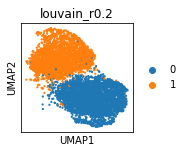

In [6]:
rcParams['figure.figsize']=2,2
rcParams["figure.facecolor"]='white'
sc.pl.umap(adata_velo, color=['louvain_r0.2'])

In [7]:
# Credit: Merging scvelo with adata - https://github.com/theislab/scvelo/issues/37

merged = scv.utils.merge(adata_velo, bdata)
print('Number of cells before merge:',len(adata_velo.obs.index))
print('Number of cells in bdata:',len(bdata.obs.index))
print('Number of cells after merge:',len(merged.obs.index))

Number of cells before merge: 6133
Number of cells in bdata: 11269
Number of cells after merge: 6133


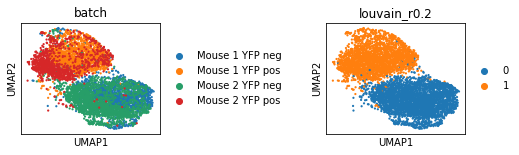

In [9]:
# Plot merged adata/loom data
sc.pl.umap(merged, color=['batch','louvain_r0.2'], ncols=2, wspace=1)

In [10]:
# Create velocity graphs
scv.tl.velocity(merged)
scv.tl.velocity_graph(merged)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


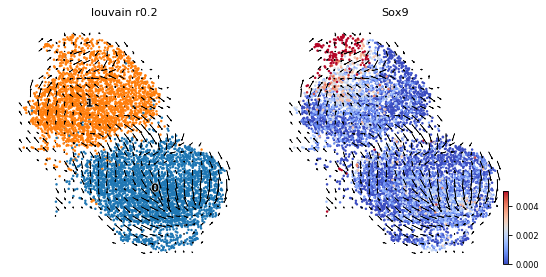

In [16]:
# Plot velocity data on pre-computed UMAP from adata
cmap='coolwarm'
arrow_color='black'
size=20
vmin=0
vmax=0.005
figsize=(4,4)
fontsize=10

genes = ['Sox9']

for gene in genes:
    merged.obs[gene]=merged[:, [gene]].to_df()

with axes_style({'axes.grid': False}):
    ax=scv.pl.velocity_embedding_grid(merged, density=0.5, basis='umap', arrow_length=2, arrow_size=1, 
    alpha=1, color=['louvain_r0.2'] + genes, legend_loc='on data', size=size, ncols = len(genes)+2, 
    figsize=figsize, dpi=(80), frameon=False, color_map=cmap, fontsize=10, vmin=vmin, vmax=vmax,
    legend_fontsize=10, arrow_color=arrow_color, linewidth=0.5)

# remove genes from merged.obs
merged.obs = merged.obs.drop(genes, axis=1)

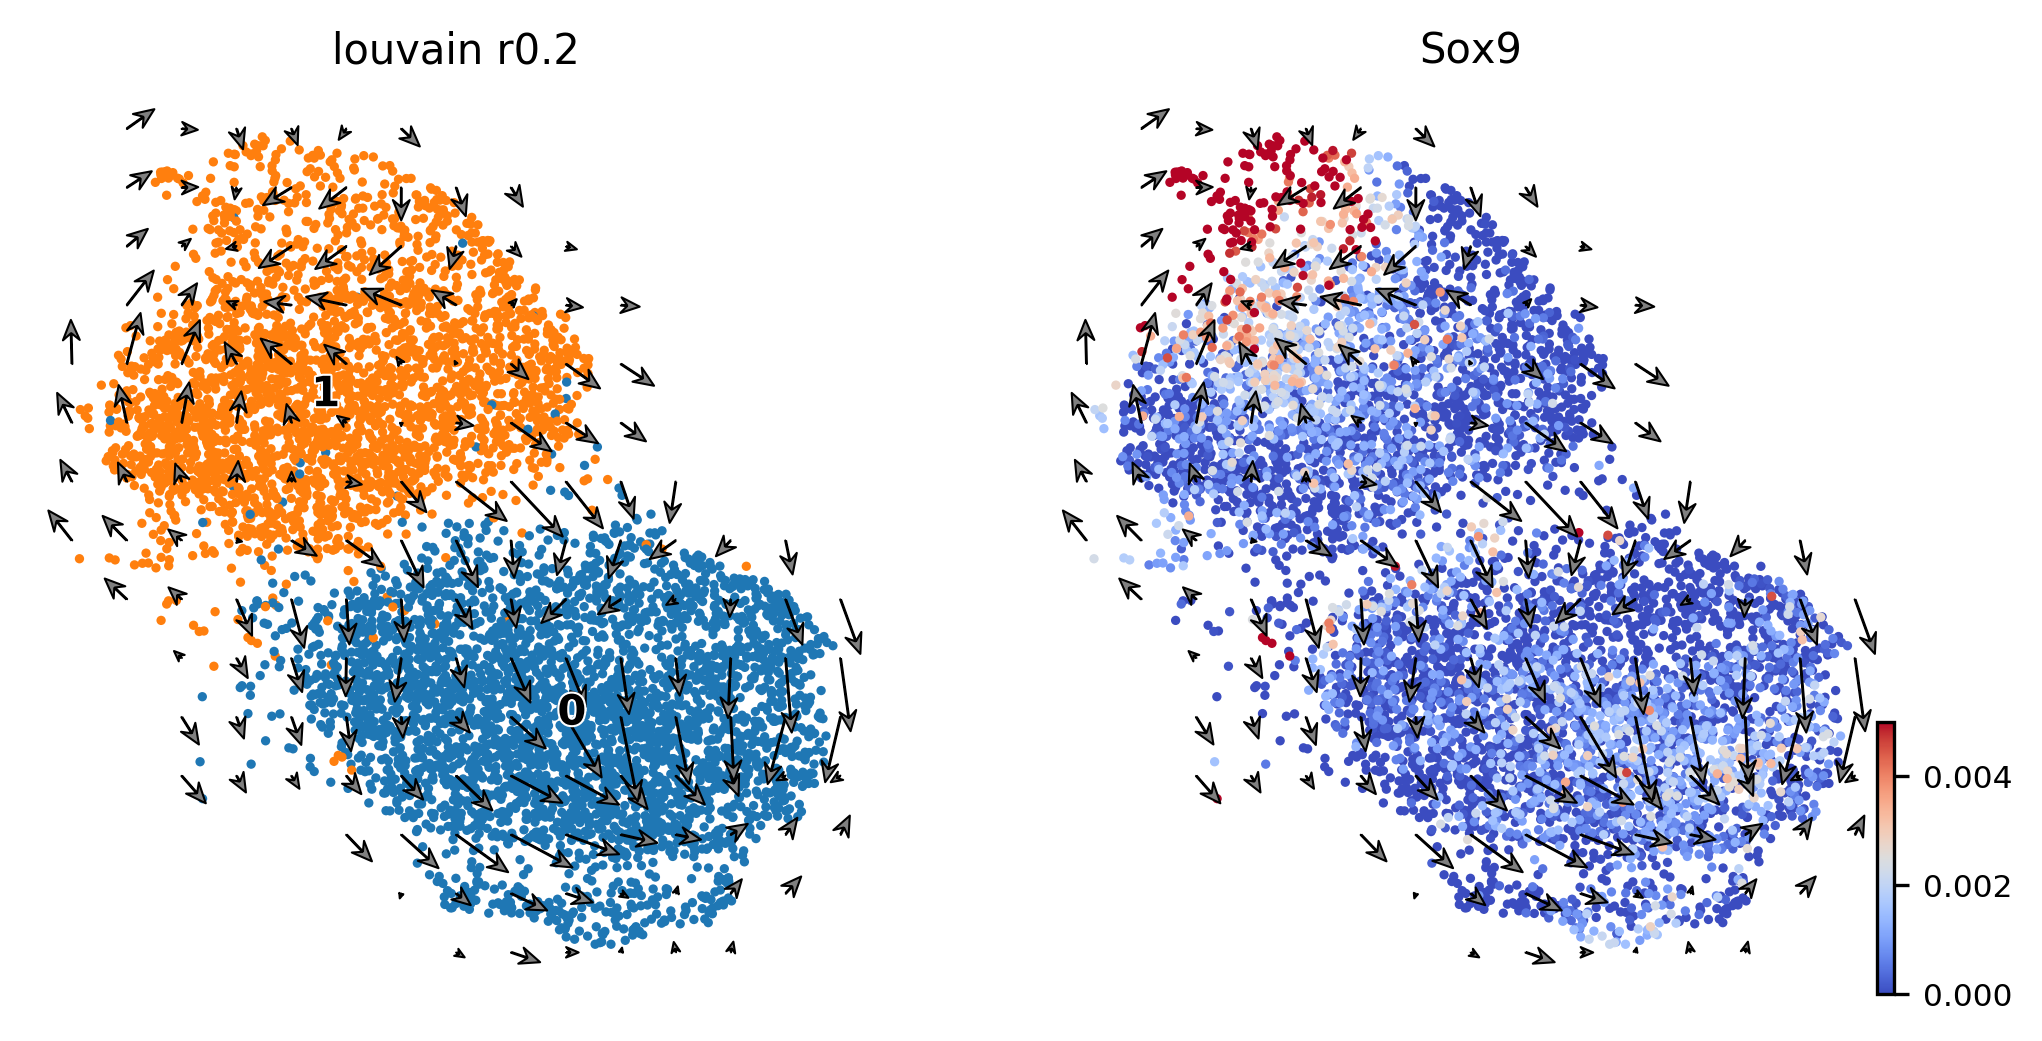

In [4]:
# add genes to merged.obs because use_raw does not work

# Plot velocity data on pre-computed UMAP from adata
cmap='coolwarm'
arrow_color='black'
size=20
vmin=0
vmax=0.005
figsize=(4,4)
fontsize=10

genes = ['Sox9']

for gene in genes:
    merged.obs[gene]=merged[:, [gene]].to_df()

with axes_style({'axes.grid': False}):
    ax=scv.pl.velocity_embedding_grid(merged, density=0.3, basis='umap', arrow_length=2, arrow_size=4, 
    alpha=1, color=['louvain_r0.2'] + genes, legend_loc='on data', size=size, ncols = len(genes)+2, 
    figsize=figsize, dpi=(300), frameon=False, color_map=cmap, fontsize=10, vmin=vmin, vmax=vmax,
    legend_fontsize=10, arrow_color=arrow_color, linewidth=0.5)

# remove genes from merged.obs
merged.obs = merged.obs.drop(genes, axis=1)

#### Save data

In [16]:
velocyto_results_file = '/n/data2/bch/hemonc/ckim/AARON/KY_epithelial_analysis/write/KY_gemm_velocyto_merged.h5ad'
merged.write(velocyto_results_file)